# CSII 2025 Exercise 04: State Feedback with Luenberger Observer

© 2025 ETH Zurich, Aya Abrini, Livia Fischer, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Authors:
- Aya Abrini
- Livia Fischer

To start, run the following cell to install the necessary modules and import the libraries.


In [4]:
!pip install numpy matplotlib scipy ipywidgets control


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: C:\Users\joel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
# Import necessary libraries
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt
# Set up matplotlib for inline plotting
%matplotlib inline
# This ensures plots are displayed directly in the notebook
from scipy.linalg import solve_continuous_are  # For solving the Riccati equation (used in Kalman filter design)
from scipy.linalg import solve_discrete_are
from scipy.signal import place_poles
from scipy.integrate import solve_ivp  # For solving differential equations
from ipywidgets import interact, FloatSlider, widgets  # For interactive sliders
import control as ct

# Exercise 1: Luenberger observer





### System Description: Linear Time-Invariant (LTI) System

This code simulates a **linear time-invariant (LTI) system** and plots its states over time. The system is given in the state-space form: 

$$\begin{bmatrix}\dot{x}_1 \\ \dot{x}_2 \end{bmatrix} = \begin{bmatrix}-1.1 & 0.4 \\ 0.25 & 0 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + \begin{bmatrix}1 \\ 0 \end{bmatrix} u,$$



$$
y = \begin{bmatrix} -1 & 0.8 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}.
$$
This first plot shows the evolution of the states. This means it solves the ODE exactly to get to a solution for $x_1(t)$ and $x_2(t)$.

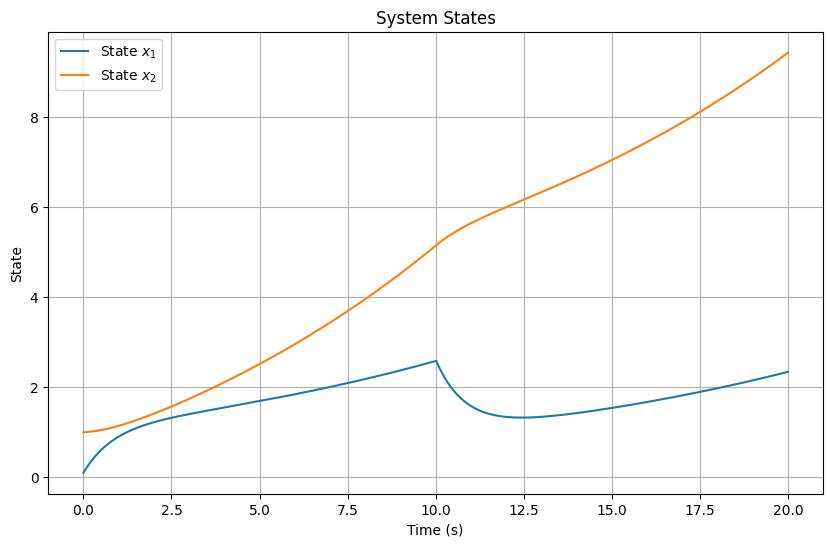

In [8]:
# Define system matrices
A = np.array([[-1.1, 0.4], [0.25, 0]])
B = np.array([[1], [0]])
C = np.array([[-1, 0.8]])

# Initial state
x0 = np.array([[0.1], [1]])

# Time parameters
dt = 0.01
t_end = 20
t = np.arange(0, t_end, dt)

# Input signal (step input)
u = np.ones_like(t)
u[t > 10] = -1  # Change input at t = 10

# Simulate the system
x = np.zeros((2, len(t)))
x[:, 0] = x0.flatten()

for i in range(1, len(t)):
    x[:, i] = x[:, i-1] + dt * (A @ x[:, i-1] + (B * u[i-1]).flatten())

# Plot the system states
plt.figure(figsize=(10, 6))
plt.plot(t, x[0, :], label='State $x_1$')
plt.plot(t, x[1, :], label='State $x_2$')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.title('System States')
plt.legend()
plt.grid()
plt.show()

This code computes the **observer gain \( L \)** using pole placement. The observer is designed to estimate the system's state by placing the observer's poles at specific locations in the complex plane. The desired poles are chosen to ensure fast and stable convergence of the observer's estimate to the true state. To start we set the desired poles at $-1+j, -1 -j$.

In [10]:
# Desired observer poles
desired_poles = np.array([-1 + 1j, -1 - 1j])

# Find observer gain using pole placement
L = place_poles(A.T, C.T, desired_poles).gain_matrix.T

print("Observer gain L:")
print(L)

Observer gain L:
[[1.95  ]
 [3.5625]]


### Observer Simulation

This code simulates the **Luenberger observer**, which estimates the system's state using the system model and measurements. The observer starts with an initial estimate of $\hat{x}_0 = 0$ and updates its estimate over time using the innovation term $y - \hat{y} $, where:
- $y$: Real measurement from the system.
- $\hat{y}$: Estimated measurement from the observer.

The observer's estimate is compared to the true state, and both are plotted over time.
From the plot you can see that the estimation converges over time to the true state. The inital error arises due to the true initial condition being unknown. over the time the system will converge if it is stable.

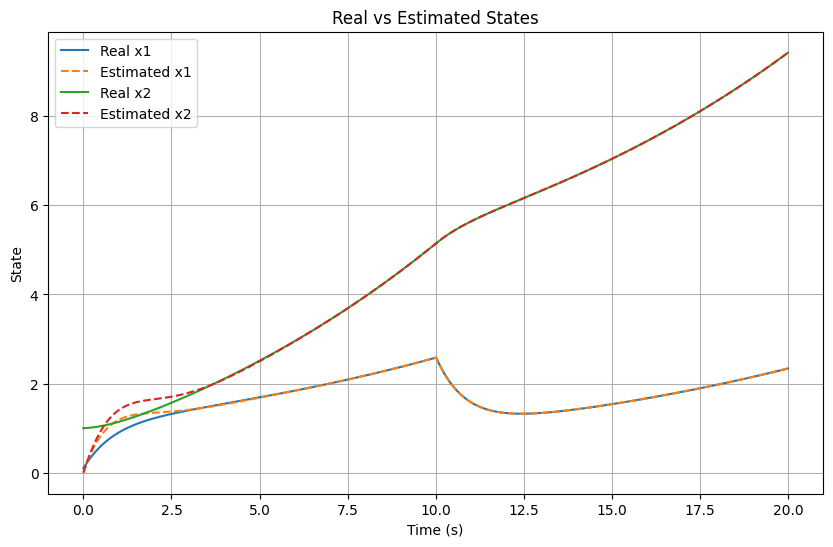

In [11]:
# Initialize states 
x_hat0 = np.array([[0], [0]]) # Initial estimate assumed to be 0
x_hat = np.zeros((2, len(t)))
x_hat[:, 0] = x_hat0.flatten()

# Simulate the observer
for i in range(1, len(t)):
    y = C @ x[:, i-1]  # Real measurement
    y_hat = C @ x_hat[:, i-1]  # Estimated measurement
    x_hat[:, i] = x_hat[:, i-1] + dt * (A @ x_hat[:, i-1] + (B * u[i-1]).flatten() + L @ (y - y_hat)) # Update the observer's state estimate

# Plot the real and estimated states
plt.figure(figsize=(10, 6))
plt.plot(t, x[0, :], label='Real x1')
plt.plot(t, x_hat[0, :], '--', label='Estimated x1')
plt.plot(t, x[1, :], label='Real x2')
plt.plot(t, x_hat[1, :], '--', label='Estimated x2')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.title('Real vs Estimated States')
plt.legend()
plt.grid()
plt.show()

The following code snippet provides an interactive tool to explore the effect of observer pole placement on a Luenberger observer. By adjusting the real and imaginary parts of the desired poles using sliders, you can see how the observer's performance changes.

In [15]:
# Interactive function to change observer poles
def simulate_observer(real_part, imag_part):
    # Desired observer poles
    desired_poles = np.array([real_part + imag_part * 1j, real_part - imag_part * 1j])

    # Compute the observer gain L
    L = place_poles(A.T, C.T, desired_poles).gain_matrix.T

    # Simulate the observer
    x_hat = np.zeros((2, len(t)))
    x_hat[:, 0] = x_hat0.flatten()

    for i in range(1, len(t)):
        y = C @ x[:, i-1]
        y_hat = C @ x_hat[:, i-1]
        x_hat[:, i] = x_hat[:, i-1] + dt * (A @ x_hat[:, i-1] + (B * u[i-1]).flatten() + L @ (y - y_hat)) # Update the observer's state estimate

    # Plot the real and estimated states
    plt.figure(figsize=(10, 6))
    plt.plot(t, x[0, :], label='Real $x_1$')
    plt.plot(t, x_hat[0, :], '--', label=f'Estimated $x_1$ (poles: {desired_poles})')
    plt.plot(t, x[1, :], label='Real $x_2$')
    plt.plot(t, x_hat[1, :], '--', label=f'Estimated $x_2$ (poles: {desired_poles})')
    plt.xlabel('Time (s)')
    plt.ylabel('State')
    plt.title('Real vs Estimated States')
    plt.legend()
    plt.grid()
    plt.show()

# Interactive widget
interact(simulate_observer,
         real_part=FloatSlider(value=-1, min=-5, max=3, step=0.5, description='Real Part:'),
         imag_part=FloatSlider(value=1, min=0.5, max=5, step=0.5, description='Imaginary Part:'));

interactive(children=(FloatSlider(value=-1.0, description='Real Part:', max=3.0, min=-5.0, step=0.5), FloatSli…

Feel free to play with the values. Try and find poles for which the system converges and diverges.
What is your conclusion for different selections?

# Exercise 2: LQE

In this exercise we assume a state-space system of the form written below. The code starts by initializing the system aswell as the initial contitions for both the true state $x(t)$ and the estimated state $\hat{x}(t)$. In a real world system, the initial condition of the true state $x(t)$ would be unknown. You can choose the value for measurement noise $n(t)$ and process noise $w(t)$ with the slider. This value stands for the square root of the maximum allowed noise. The actual value will be computed for each time step as a random number in the interval $[0,\sqrt{noise}]$.
The equations of the system are given by:
$$
\dot{x}  = A x + B u + w(t),
$$
$$
y_m = C x + n(t).
$$

In [16]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Define system parameters
dt = 0.1 # Time step (not used explicitly in this simple example)
A = 1.0        
B = 0.0        
C = 1.0        
u = 0.0        

# Simulation length
T = 50

# Function that evaluates states
def kalman_filter(Q_actual, R_actual, Q_filter, R_filter):
    """
    Simulate a 1D Kalman filter where:
      - Q_actual and R_actual determine the true process and measurement noise,
      - Q_filter and R_filter are the noise covariances used by the Kalman filter.
    
    Parameters:
    - Q_actual: Variance of the actual process noise.
    - R_actual: Variance of the actual measurement noise.
    - Q_filter: Process noise covariance assumed by the filter.
    - R_filter: Measurement noise covariance assumed by the filter.
    """
    # For reproducibility
    np.random.seed(42)
    
    # Initial true state and estimate
    x_true = 0.0
    x_est = 0.0
    P_est = 1.0  # Initial estimation error covariance

    # Generate noise sequences with the actual noise variances
    process_noise = np.random.normal(0, np.sqrt(Q_actual), T)
    measurement_noise = np.random.normal(0, np.sqrt(R_actual), T)
    
    # Arrays to store simulation results
    x_true_vals = np.zeros(T)
    x_measured_vals = np.zeros(T)
    x_est_vals = np.zeros(T)
    P_vals = np.zeros(T)
    
    # Set initial values
    x_true_vals[0] = x_true
    x_measured_vals[0] = x_true + measurement_noise[0]
    x_est_vals[0] = x_est
    P_vals[0] = P_est
    
    # Simulation loop
    for t in range(1, T):
        # ----- True System Evolution -----
        # Evolve the true state with process noise
        x_true = A * x_true + process_noise[t]
        x_true_vals[t] = x_true
        
        # Generate the measurement (true state + measurement noise)
        x_measured = C * x_true + measurement_noise[t]
        x_measured_vals[t] = x_measured
        
        # ----- Kalman Filter Prediction -----
        x_pred = A * x_est  # Predicted state estimate (no control input)
        P_pred = A * P_est * A + Q_filter  # Predicted error covariance
        
        # ----- Kalman Filter Update -----
        K = P_pred * C / (C * P_pred * C + R_filter)  # Kalman gain
        x_est = x_pred + K * (x_measured - C * x_pred)  # Updated state estimate
        P_est = (1 - K * C) * P_pred                    # Updated error covariance
        
        # Store filter estimates for plotting
        x_est_vals[t] = x_est
        P_vals[t] = P_est
        
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x_true_vals, label="True State", marker='o')
    plt.plot(x_measured_vals, label="Measured", linestyle="--", marker='x')
    plt.plot(x_est_vals, label="Estimated State", marker='s')
    plt.xlabel("Time Step")
    plt.ylabel("State Value")
    plt.title("Kalman Filter with Mismatched Noise Parameters")
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive sliders for the actual noise and filter noise parameters
interact(kalman_filter,
         Q_actual=FloatSlider(value=0.1, min=0.0001, max=10, step=0.01, description='Actual Process Noise Q:'),
         R_actual=FloatSlider(value=0.1, min=0.0001, max=10, step=0.01, description='Actual Measurement Noise R:'),
         Q_filter=FloatSlider(value=0.1, min=0.0001, max=10, step=0.01, description='Filter Process Noise Q:'),
         R_filter=FloatSlider(value=0.1, min=0.0001, max=10, step=0.01, description='Filter Measurement Noise R:'))


interactive(children=(FloatSlider(value=0.1, description='Actual Process Noise Q:', max=10.0, min=0.0001, step…

<function __main__.kalman_filter(Q_actual, R_actual, Q_filter, R_filter)>

Try and change the values of the noise and the weights.
For high measurement noise and low process noise: do you expect better estimations for high R or Q?

## Exercise 3: Kalman filter

### System Description: Drone Altitude Control  

This system models a **drone trying to maintain a desired altitude**. The drone's dynamics are described by:  

#### **States:**  
- $x_1$: Altitude (position) of the drone.  
- $x_2$: Vertical velocity of the drone.  

#### **Forces:**  
- **Thrust** $u$: Control input from the drone's propellers.  
- **Air Resistance**: Modeled as $-k x_1$.  
- **Damping**: Modeled as $-c x_2$.  

#### **State-Space Equations:**  
$$
\dot{x} = A x + B u,
$$
$$
y = C x.
$$  
where:  
- $A$: State matrix (system dynamics).  
- $B$: Input matrix (effect of thrust).  
- $C$: Output matrix (measures altitude).  

The goal is to estimate the drone's altitude and velocity using a **Kalman filter** in the presence of process and measurement noise.

In [17]:
# System parameters
m = 1.0  # Mass of the drone (kg)
k = 0.5  # Spring constant (air resistance)
c = 0.2  # Damping coefficient

# State-space matrices (continuous-time)
A_cont = np.array([[0, 1], [-k/m, -c/m]])
B_cont = np.array([[0], [1/m]])
C = np.array([[1, 0]])  # Measure altitude only

# Discretize the system (assuming a small time step dt)
dt = 0.1  # Time step
A = np.eye(2) + A_cont * dt  # Discrete-time state matrix
B = B_cont * dt  # Discrete-time input matrix


In [ ]:
def design_kalman_filter(A, C, Q, R):
    """Design Kalman filter gain L_kf."""
    P = solve_discrete_are(A.T, C.T, Q, R) # Solving the discrete-time algebraic Riccati equation (DARE) to find P
    L_kf = P @ C.T @ np.linalg.inv(C @ P @ C.T + R)
    return L_kf

# Noise covariance matrices
Q = np.eye(2) * 0.1  # Process noise covariance (model inaccuracies)
R = np.eye(1) * 1.0  # Measurement noise covariance (sensor inaccuracies)

# Kalman filter gain
L_kf = design_kalman_filter(A, C, Q, R)
print("Kalman Filter Gain L_kf:", L_kf)

Kalman Filter Gain L_kf: [[0.31489289]
 [0.17288439]]


### Drone Altitude Estimation with Kalman Filter

This code simulates a **drone's altitude control system** using a Kalman filter to estimate the altitude in the presence of process and measurement noise. The system is subject to:
- **Process Noise**: Represents uncertainties in the system model (e.g., wind gusts).
- **Measurement Noise**: Represents uncertainties in the sensor measurements (e.g., altitude sensor errors).

The Kalman filter dynamically updates its estimate of the drone's altitude by balancing trust in the system model and the sensor measurements. The true altitude and the Kalman filter's estimate are plotted over time for comparison.

In [20]:
def simulate_system(noise=False, T=10, process_noise=0.1, measurement_noise=1.0):
    """Simulate the system with Kalman filter."""
    # Time parameters
    num_steps = int(T / dt)
    t = np.arange(0, T, dt)

    # Input function (thrust profile)
    def u(k):
        return 1.0 if k * dt < 5 else 0.0  # Apply thrust for 5 seconds

    # Initial conditions (as 2D column vectors)
    x = np.array([[0.0], [0.0]])  # True initial state (altitude and velocity)
    x_hat = np.array([[0.0], [0.0]])  # Observer initial estimate

    # Adjust noise covariance matrices
    Q = np.eye(2) * process_noise  # Process noise covariance (2x2)
    R = np.eye(1) * measurement_noise  # Measurement noise covariance (1x1)

    # Arrays to store results
    x_history = np.zeros((2, num_steps))
    x_hat_history = np.zeros((2, num_steps))

    # Simulate the system
    for k in range(num_steps):
        # Process noise (if enabled)
        w = np.random.multivariate_normal([0, 0], Q).reshape(-1, 1) if noise else np.zeros((2, 1))

        # Sensor noise (if enabled)
        n = np.random.normal(0, np.sqrt(R[0,0])) if noise else 0

        # True system dynamics
        x = A @ x + B * u(k) + w  # All terms are (2x1)
        y = C @ x + n  # Noisy measurement (scalar)

        # Kalman filter
        innovation = y - C @ x_hat  # Innovation term (scalar)
        x_hat = A @ x_hat + B * u(k) + L_kf * innovation  # L_kf * innovation is (2x1)

        # Store results
        x_history[:, k] = x.flatten()
        x_hat_history[:, k] = x_hat.flatten()

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(t, x_history[0, :], 'k', label='True Altitude')
    plt.plot(t, x_hat_history[0, :], 'b--', label='Kalman Filter Estimate')
    plt.xlabel('Time (s)')
    plt.ylabel('Altitude (m)')
    plt.title('Drone Altitude Estimation with Kalman Filter')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
# Interactive widget for noise and simulation time
@interact(
    process_noise=FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='Process Noise (Q):'),
    measurement_noise=FloatSlider(value=1.0, min=0.1, max=10.0, step=0.1, description='Measurement Noise (R):'),
    T=FloatSlider(value=10, min=5, max=20, step=1, description='Simulation Time:')
)
def interactive_simulation(process_noise, measurement_noise, T):
    """Interactive simulation with noise and time controls."""
    simulate_system(noise=True, T=T, process_noise=process_noise, measurement_noise=measurement_noise)

interactive(children=(FloatSlider(value=0.1, description='Process Noise (Q):', max=1.0, min=0.01, step=0.01), …